In [1]:
import os
import pandas as pd
import qiime2 as q2
from biom import Table, load_table
from qiime2 import Artifact
from qiime2 import Metadata
import numpy as np
import random
import time
from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.phylogeny.methods import filter_table
from qiime2.plugins.gemelli.actions import (rpca, phylogenetic_rpca_without_taxonomy,
                                            phylogenetic_rpca_with_taxonomy)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance
from qiime2.plugins.feature_table.methods import rarefy
from skbio.stats.distance import permanova
np.random.seed(42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import data
table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                load_table('../../data/Westernization-Qiita-10333/urbmerged.biom'))
metadata = q2.Metadata.load('../../data/Westernization-Qiita-10333/10333_20190808-130957.txt')
tree = q2.Artifact.load('../../data/Westernization-Qiita-10333/sepp-tree/tree.qza')
table = filter_table(table, tree).filtered_table
taxonomy = q2.Artifact.load('../../data/Westernization-Qiita-10333/taxonomy.qza')

# remove controls
mf = metadata.to_dataframe()
mf = mf[mf.host_body_site == 'UBERON:skin of hand']
mf = mf[mf.village != 'Puerto Almendras']
mf = mf[mf.house_number.isin([k for k, v in mf.house_number.value_counts().items()
                              if v >= 3])]

# keep shared IDs
bt = table.view(Table)
shared_ = set(bt.ids()) & set(mf.index)
bt = bt.filter(shared_)
mf = mf.reindex(shared_)
metadata = q2.Metadata(mf)

# filter out zero sums
n_features, n_samples = bt.shape
# filter features by N samples presence
min_feature_frequency = 10
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
min_feature_count = 10
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt = bt.filter(observation_filter, axis='observation')
#bt = bt.filter(bt.ids('observation')[(bt.sum('observation') > 0)], axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > 0)])

# re-import
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
bt


1443 x 164 <class 'biom.table.Table'> with 60317 nonzero entries (25% dense)

In [3]:
# add real data
simulation_results = {}
bt_sim_tmp = table.view(Table).copy()
rare_depth = int(np.percentile(bt_sim_tmp.sum('sample'), 25))
keep_ids = bt_sim_tmp.ids()[bt_sim_tmp.sum('sample') > rare_depth]
bt_sim_tmp = bt_sim_tmp.filter(keep_ids)
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]',
                                        bt_sim_tmp)
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]', bt_sim_tmp)
# rare for other methods
table_rare_tmp = rarefy(table_sim_tmp, rare_depth, with_replacement=True).rarefied_table
bt_sim_tmp = bt_sim_tmp.filter(table_rare_tmp.view(Table).ids('observation'), axis='observation')
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]', bt_sim_tmp)
mf_tmp = metadata.to_dataframe().copy().reindex(bt_sim_tmp.ids())
table_sim_tmp.save('../../results/Westernization-Qiita-10333-results/filtered-input-table.qza')
mf_tmp.to_csv('../../results/Westernization-Qiita-10333-results/filtered-input-metadata.tsv', sep='\t')
simulation_results[rare_depth] = (table_rare_tmp, table_sim_tmp, mf_tmp)

table_characteristics = {(k, ttype):[t.view(Table).shape[1],
                            t.view(Table).shape[0],
                            np.percentile(t.view(Table).sum('sample'), 25),
                            t.view(Table).sum('sample').mean(),
                            np.median(t.view(Table).sum('sample')),
                            t.view(Table).sum('sample').std() / t.view(Table).sum('sample').mean(),
                            t.view(Table).sum('sample').std(),
                            t.view(Table).sum('sample').min(),
                            t.view(Table).sum('sample').max(),
                            (t.view(Table).nnz /\
                             (t.view(Table).shape[0] * t.view(Table).shape[1])) * 100]
                         for k, tab in simulation_results.items()
                         for t, ttype in zip(tab[:-1], [True, False])}
table_characteristics = pd.DataFrame(table_characteristics, ['n-samples','n-features','rare-75%',
                                                             'mean','median',
                                                             'coeff','std','min','max','% observed']).T
table_characteristics.index.names = ['estimate-depth', 'rare']
table_characteristics.head(10)


n-samples  n-features  rare-75%          mean   median  \
estimate-depth rare                                                            
29420          True       123.0      1443.0   29420.0  29420.000000  29420.0   
               False      123.0      1443.0   36573.5  63939.894309  52497.0   

                        coeff           std      min       max  % observed  
estimate-depth rare                                                         
29420          True   0.00000      0.000000  29420.0   29420.0   24.600961  
               False  0.64481  41229.068189  29690.0  376669.0   26.599958

In [4]:
bt_test = simulation_results[29420][1].view(Table)
tst_btdf = pd.DataFrame(bt_test.matrix_data.toarray(),
                        bt_test.ids('observation'), bt_test.ids())
tst_btdf.to_csv('../../results/benchmarking/cross-sectional/data/table.tsv',sep='\t')
tntree = tree.view(TreeNode)
tntree = tntree.shear(bt.ids('observation'))
tntree.prune()
tntree.write('../../results/benchmarking/cross-sectional/data/tree.nwk')

'../../results/benchmarking/cross-sectional/data/tree.nwk'

In [5]:
information_unifrac = pd.read_csv("../../results/benchmarking/cross-sectional/metrics/information-unifrac.csv", index_col=0)
ratio_unifrac = pd.read_csv("../../results/benchmarking/cross-sectional/metrics/ratio-unifrac.csv", index_col=0)
information_unifrac = DistanceMatrix(information_unifrac, ids=information_unifrac.index)
ratio_unifrac = DistanceMatrix(ratio_unifrac, ids=ratio_unifrac.index)
information_unifrac = q2.Artifact.import_data('DistanceMatrix', information_unifrac)
ratio_unifrac = q2.Artifact.import_data('DistanceMatrix', ratio_unifrac)
information_unifrac_pcoa = pcoa(information_unifrac)
ratio_unifrac_pcoa = pcoa(ratio_unifrac)


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.06815698121021099 and the largest is 2.323492863395593.
  RuntimeWarning
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the result

In [6]:
simulation_metrics = {}
metric_time = {}

for sim_char, (table_rare_tmp, table_sim_tmp, mf_tmp) in simulation_results.items():
    
    # run default phylo RPCA
    start_time = time.time()
    #phylo_rpca_tmp = phylogenetic_rpca_with_taxonomy(table_sim_tmp, tree, taxonomy.view(q2.Metadata), min_depth=1000)
    phylo_rpca_tmp = phylogenetic_rpca_without_taxonomy(table_sim_tmp, tree, min_depth=500)
                                                        #min_depth=1000)
    metric_time['Phylo-RPCA'] = time.time() - start_time

    # RPCA
    start_time = time.time()
    rpca_tmp = rpca(table_sim_tmp)
    metric_time['RPCA'] = time.time() - start_time

    # run unifrac(s)
    start_time = time.time()
    unweighted_unifrac_distance_tmp = beta_phylogenetic(table_rare_tmp, tree,
                                                    'unweighted_unifrac')
    unweighted_unifrac_pcoa_tmp = pcoa(unweighted_unifrac_distance_tmp.distance_matrix)
    metric_time['unweighted UniFrac'] = time.time() - start_time

    start_time = time.time()
    jaccard_distance_tmp = beta(table_rare_tmp, 'jaccard')
    jaccard_pcoa_tmp = pcoa(jaccard_distance_tmp.distance_matrix)
    metric_time['Jaccard'] = time.time() - start_time
    
    start_time = time.time()
    braycurtis_distance_tmp = beta(table_rare_tmp, 'braycurtis')
    braycurtis_pcoa_tmp = pcoa(braycurtis_distance_tmp.distance_matrix)
    metric_time['Bray-Curtis'] = time.time() - start_time
    
    
    start_time = time.time()
    aitchison_distance_tmp = beta(table_sim_tmp, 'aitchison')
    aitchison_pcoa_tmp = pcoa(aitchison_distance_tmp.distance_matrix)
    metric_time['Aitchison'] = time.time() - start_time

    
    unifracs_dist_tmp = {'unweighted UniFrac':unweighted_unifrac_distance_tmp.distance_matrix.view(DistanceMatrix),
                         'Jaccard':jaccard_distance_tmp.distance_matrix.view(DistanceMatrix),
                         'Bray-Curtis':braycurtis_distance_tmp.distance_matrix.view(DistanceMatrix)}
    unifracs_ord_tmp = {'unweighted UniFrac':unweighted_unifrac_pcoa_tmp.pcoa.view(OrdinationResults),
                        'Jaccard':jaccard_pcoa_tmp.pcoa.view(OrdinationResults),
                        'Bray-Curtis':braycurtis_pcoa_tmp.pcoa.view(OrdinationResults)}

    for alpha_ in np.arange(0.0, 1.1, .1):
        start_time = time.time()
        unifrac_distance_tmp = beta_phylogenetic(table_rare_tmp, tree, 'generalized_unifrac', alpha=alpha_)
        unifracs_dist_tmp['Generalized UniFrac ($\\alpha$=%.1f)' % (alpha_)] = unifrac_distance_tmp.distance_matrix.view(DistanceMatrix)
        unifrac_pcoa_tmp = pcoa(unifrac_distance_tmp.distance_matrix)
        unifracs_ord_tmp['Generalized UniFrac ($\\alpha$=%.1f)' % (alpha_)] = unifrac_pcoa_tmp.pcoa.view(OrdinationResults)
        metric_time['Generalized UniFrac ($\\alpha$=%.1f)' % (alpha_)] = time.time() - start_time

        
    # save results
    distances_tmp = {'Phylo-RPCA':phylo_rpca_tmp.distance_matrix.view(DistanceMatrix),
                     'RPCA':rpca_tmp.distance_matrix.view(DistanceMatrix),
                     'Aitchison':aitchison_distance_tmp.distance_matrix.view(DistanceMatrix),
                     'Ratio-UniFrac':ratio_unifrac.view(DistanceMatrix),
                     'Information-UniFrac':information_unifrac.view(DistanceMatrix)}

    distances_tmp = {**distances_tmp, **unifracs_dist_tmp}

    ordinations_tmp = {'Phylo-RPCA': phylo_rpca_tmp.biplot.view(OrdinationResults),
                        'RPCA': rpca_tmp.biplot.view(OrdinationResults),
                       'Aitchison': aitchison_pcoa_tmp.pcoa.view(OrdinationResults),
                       'Ratio-UniFrac': ratio_unifrac_pcoa.pcoa.view(OrdinationResults),
                       'Information-UniFrac': information_unifrac_pcoa.pcoa.view(OrdinationResults)}

    ordinations_tmp = {**ordinations_tmp, **unifracs_ord_tmp}
    
    simulation_metrics[sim_char] = [distances_tmp, ordinations_tmp]
    

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.005091325454937621 and the largest is 4.066671370288018.
  RuntimeWarning
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result c

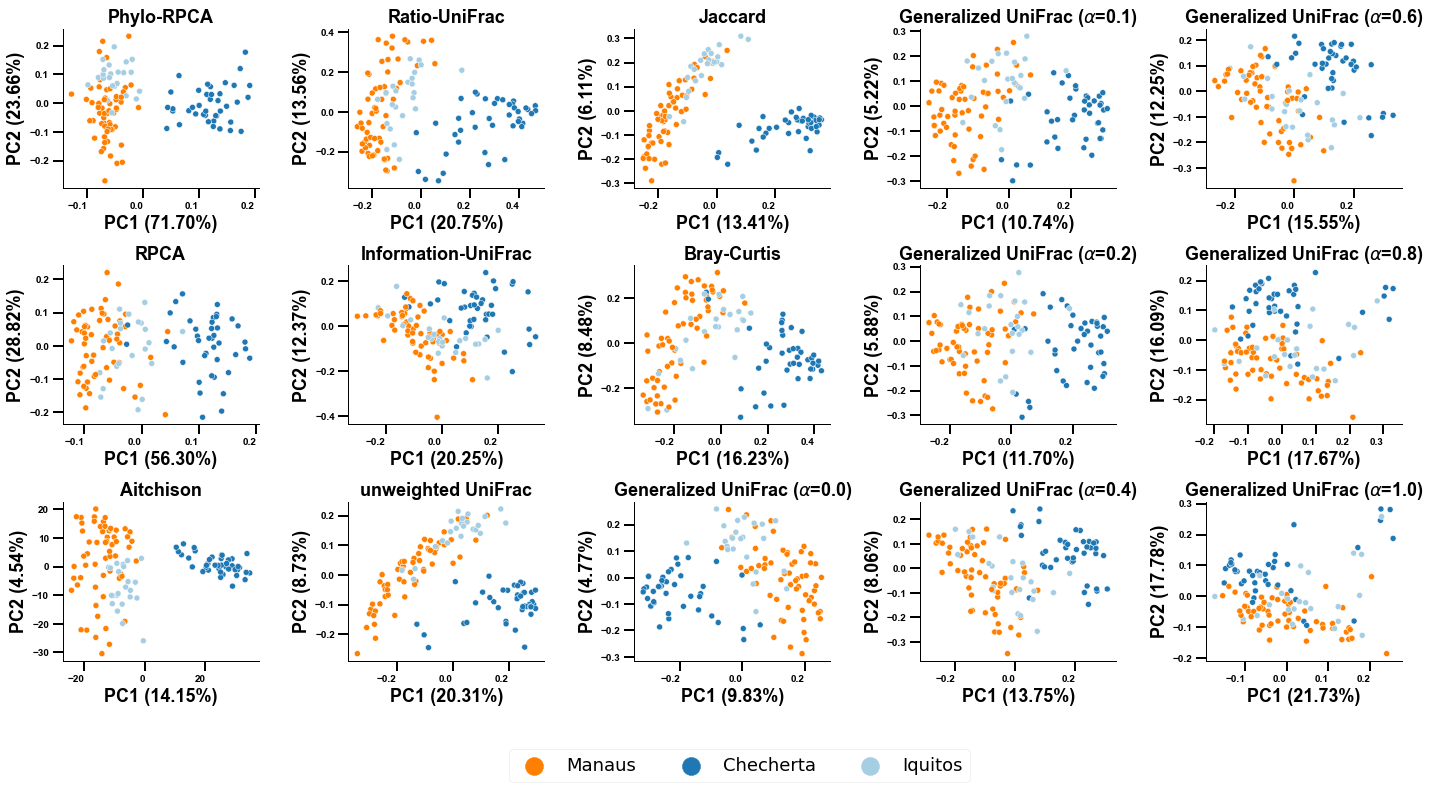

In [13]:
catagory = 'village'
pal_use = {'Checherta':'#1f78b4',
           'Iquitos':'#a6cee3',
           'Manaus':'#ff7f00'}


fig, axn = plt.subplots(3, 5,figsize=(20, 10))

simulation_metrics_plot = {}
for method, ord_ in  simulation_metrics[29420][1].items():
    if '\\alpha$=' in method:
        if (int(float(method.split('\\alpha$=')[1][:-1]) * 10) % 2 != 0) \
        & (float(method.split('\\alpha$=')[1][:-1]) != 0.1):
            continue
    simulation_metrics_plot[method] = ord_

for (method, ord_), ax in zip(simulation_metrics_plot.items(), axn.T.flatten()):


    ord_tmp = ord_.samples[[0, 1, 2]].copy()
    mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
    ord_tmp = pd.concat([ord_tmp, mf_tmp[list(set([catagory, 'house_number']))]],
                        axis=1, sort=False).dropna(subset=[0, catagory])
    ord_tmp[catagory] = ord_tmp[catagory].astype(str)
    ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
        
    sns.scatterplot(x=0, y=1, hue=catagory,
                    data=ord_tmp, ax=ax, palette=pal_use)
    ax.set_title(method,
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.legend_.remove()
    
    
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(10)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(10)
    ax.set_ylabel('PC2 (%.2f%%)' % (ord_.proportion_explained[1] * 100 ),
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('PC1 (%.2f%%)' % (ord_.proportion_explained[0] * 100 ),
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    
plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:], labels[:],
          loc=2, bbox_to_anchor=(-3.6, -0.50),
          prop={'size':18},
          fancybox=True, framealpha=0.5, 
          ncol=3, markerscale=3,
          facecolor="white")


plt.savefig('../../results/figures/westernization-scatterplots.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


In [28]:
ml_results = {}
catagory = 'geo_loc_name'

for sim_char, (distances, ordinations) in simulation_metrics.items(): 

    # save results
    res_tmp_macro = {}


    for method, ord_ in ordinations.items():

        ord_tmp = ord_.samples[[0, 1, 2]].copy()
        mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
        ord_tmp = pd.concat([ord_tmp, mf_tmp[list(set([catagory, 'house_number']))]],
                            axis=1, sort=False).dropna(subset=[0, catagory])
        ord_tmp[catagory] = ord_tmp[catagory].astype(str)
        ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
        #ord_tmp = ord_tmp[ord_tmp.house_number.isin([k for k, v in ord_tmp.house_number.value_counts().items() if v >= 3])]
        X = ord_tmp[[0, 1, 2]].values
        sids = ord_tmp.index
        classes_ = list(set(ord_tmp[catagory].values.ravel()))
        y = label_binarize(ord_tmp[catagory].values.ravel(), classes=classes_)
        # instantiate the grid
        sss = StratifiedShuffleSplit(n_splits=10,
                                     test_size=0.5,
                                     random_state=42)
        sss.get_n_splits(X, y)

        # for each split run classifier
        for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
            # split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # predict
            classifier = KNeighborsClassifier(n_neighbors=40)
            model_tmp = classifier.fit(X_train, y_train)
            y_score = model_tmp.predict_proba(X_test)
            y_score = np.vstack([y_score_class[:, 1] for y_score_class in y_score]).T
            avergage_roc_auc = roc_auc_score(y_test, y_score, average='macro')
            avergage_aps_auc = average_precision_score(y_test, y_score)   
            res_tmp_macro[(method, fold, 'PR-AUC')] = [avergage_aps_auc]
            #res_tmp_macro[(method, fold, 'ROC-AUC')] = [avergage_roc_auc]


    res_tmp_macro_df = pd.DataFrame(res_tmp_macro, ['score']).T.reset_index()
    res_tmp_macro_df.columns = ['method','fold','evaluation','score']
    ml_results[(catagory, sim_char)] = res_tmp_macro_df



In [52]:
perm_results = {}

for sim_char, (distances, ordinations) in simulation_metrics.items(): 
    print(sim_char)

    # save results
    res_tmp_fstat = {}

    for method, ord_ in ordinations.items():

        dist_tmp = distances[method]
        ord_tmp_sup = ord_tmp.loc[dist_tmp.ids, list(set([catagory, 'house_number']))].dropna()
        #ord_tmp_sup = ord_tmp_sup[ord_tmp_sup.house_number.isin([k for k, v in ord_tmp_sup.house_number.value_counts().items() if v > 3])]
        dist_tmp = dist_tmp.filter(ord_tmp_sup.index)
        permanova_tmp = permanova(dist_tmp, 
                                  ord_tmp_sup.loc[dist_tmp.ids, catagory],
                                  permutations=1000)
        # F-stat    
        res_tmp_fstat[(method, 0, 'PERMANOVA: F-statistic')] = [permanova_tmp['test statistic']]
            
    res_tmp_fstat_df = pd.DataFrame(res_tmp_fstat, ['score']).T.reset_index()
    res_tmp_fstat_df.columns = ['method','fold','evaluation','score']
    perm_results[sim_char] = res_tmp_fstat_df


29420


In [53]:
ml_results_all = pd.concat(ml_results)
ml_results_all = pd.concat([ml_results_all, pd.concat(perm_results)])
ml_results_all = ml_results_all.reset_index()
ml_results_all.head(2)


,index,method,fold,evaluation,score
0,"(geo_loc_name, 29420, 0)",Phylo-RPCA,0,PR-AUC,0.901677
1,"(geo_loc_name, 29420, 1)",Phylo-RPCA,1,PR-AUC,0.885203


/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


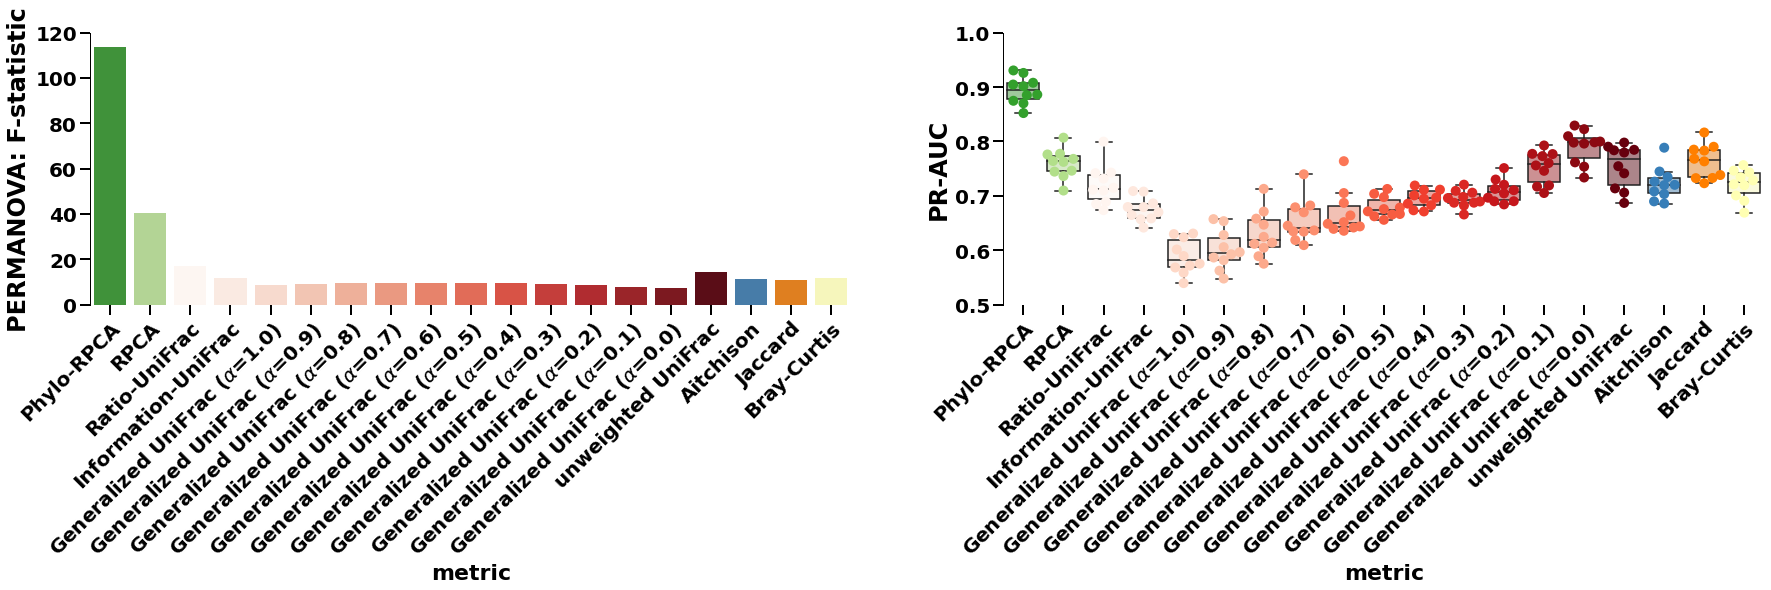

In [54]:
from matplotlib.pyplot import cm

metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' in m.lower()])
metrics_ =  metrics_[:-1][::-1] + [metrics_[-1]]
color = cm.Reds(np.linspace(0, 1, len(metrics_)))
pallete_unifrac = {i:c for i, c in zip(metrics_, color)}
metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' not in m.lower()])
color = cm.Paired(np.linspace(0, 1, len(metrics_)))
pallete_other = {i:c for i, c in zip(metrics_, color)}
pallete_other = {'Phylo-RPCA':'#33a02c','RPCA':'#b2df8a'}
   
pallete_metric = {**pallete_other, **pallete_unifrac, **{'Aitchison':'#377eb8',
                                                         'Jaccard':'#ff7f00',
                                                         'Bray-Curtis':'#ffffb3'}}

fig, axn = plt.subplots(1, 2, figsize=(30, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.barplot(x='method', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, 120)
        ax.spines['left'].set_bounds(0, 120)        
    else:

        sns.swarmplot(x='method', y='score', palette=pallete_metric,
                      order=pallete_metric.keys(),
                      s=10, data=pltdf, dodge=True, ax=ax)
        sns.boxplot(x='method', y='score', palette=pallete_metric,
                    order=pallete_metric.keys(),
                    data=pltdf, ax=ax, showfliers=False)
        ax.set_ylim(round(pltdf['score'].min() - .05, 1), 1)
        ax.spines['left'].set_bounds(round(pltdf['score'].min() - .05, 1), 1)
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 0.5))
        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    for tick in ax.get_yticklabels():
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    ax.set_xlabel('metric',
                  fontsize=22,
                  weight='bold',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  weight='bold',
                  color='black')

plt.savefig('../../results/figures/benchmark-case-study-cross-sectional.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor())
plt.show()


In [55]:

fold_change = {}
eval_methods = set(ml_results_all.evaluation)
for metric_eval in eval_methods:
    fold_change[metric_eval] = {}
    score_base = ml_results_all[(ml_results_all.method == 'Phylo-RPCA') & (ml_results_all.evaluation == metric_eval)]['score'].mean()
    for method_k, method_df in ml_results_all[(ml_results_all.method != 'Phylo-RPCA')].groupby('method'):
        score_tmp = method_df[(method_df.evaluation == metric_eval)]['score'].mean()
        if metric_eval == 'PERMANOVA: F-statistic':
            fold_change[metric_eval][method_k] = score_base / score_tmp
        else:
            fold_change[metric_eval][method_k] = (score_base - score_tmp) * 100
    
fold_change = pd.DataFrame(fold_change).reindex(pallete_metric.keys()).fillna(1).round(2)
fold_change = fold_change[['PERMANOVA: F-statistic', 'PR-AUC']]
fold_change

,PERMANOVA: F-statistic,PR-AUC
Phylo-RPCA,1.00,1.00
RPCA,2.81,13.48
Ratio-UniFrac,6.71,17.41
Information-UniFrac,9.54,21.87
Generalized UniFrac ($\alpha$=1.0),12.92,30.53
Generalized UniFrac ($\alpha$=0.9),12.48,29.29
Generalized UniFrac ($\alpha$=0.8),12.13,26.33
Generalized UniFrac ($\alpha$=0.7),11.89,23.91
Generalized UniFrac ($\alpha$=0.6),11.80,22.60
Generalized UniFrac ($\alpha$=0.5),11.88,21.50


In [56]:
runtime_df = pd.DataFrame(pd.Series(metric_time), columns = ['runtime (s)'])
runtime_df

,runtime (s)
Phylo-RPCA,2.919996
RPCA,0.797634
unweighted UniFrac,2.789945
Jaccard,0.304790
Bray-Curtis,0.464344
Aitchison,1.885795
Generalized UniFrac ($\alpha$=0.0),2.508436
Generalized UniFrac ($\alpha$=0.1),3.020755
Generalized UniFrac ($\alpha$=0.2),2.880662
Generalized UniFrac ($\alpha$=0.3),3.060503


In [41]:

fold_change = {}
eval_methods = set(ml_results_all.evaluation)
for metric_eval in eval_methods:
    fold_change[metric_eval] = {}
    score_base = ml_results_all[(ml_results_all.method == 'Phylo-RPCA') & (ml_results_all.evaluation == metric_eval)]['score'].mean()
    for method_k, method_df in ml_results_all[(ml_results_all.method != 'Phylo-RPCA')].groupby('method'):
        score_tmp = method_df[(method_df.evaluation == metric_eval)]['score'].mean()
        fold_change[metric_eval][method_k] = score_base / score_tmp

fold_change = pd.DataFrame(fold_change).reindex(pallete_metric.keys()).fillna(1).round(2)
fold_change = fold_change[['PERMANOVA: F-statistic', 'PR-AUC', 'ROC-AUC']]
fold_change


,PERMANOVA: F-statistic,PR-AUC,ROC-AUC
Phylo-RPCA,1.00,1.00,1.00
RPCA,1.98,1.19,1.17
Generalized UniFrac ($\alpha$=1.0),9.10,1.48,1.27
Generalized UniFrac ($\alpha$=0.9),8.79,1.38,1.22
Generalized UniFrac ($\alpha$=0.8),8.55,1.30,1.18
Generalized UniFrac ($\alpha$=0.7),8.38,1.26,1.16
Generalized UniFrac ($\alpha$=0.6),8.31,1.23,1.15
Generalized UniFrac ($\alpha$=0.5),8.38,1.20,1.14
Generalized UniFrac ($\alpha$=0.4),8.59,1.18,1.16
Generalized UniFrac ($\alpha$=0.3),8.98,1.19,1.17


In [42]:

fold_change = {}
eval_methods = set(ml_results_all.evaluation)
for metric_eval in eval_methods:
    fold_change[metric_eval] = {}
    score_base = ml_results_all[(ml_results_all.method == 'Phylo-RPCA') & (ml_results_all.evaluation == metric_eval)]['score'].mean()
    for method_k, method_df in ml_results_all[(ml_results_all.method != 'Phylo-RPCA')].groupby('method'):
        score_tmp = method_df[(method_df.evaluation == metric_eval)]['score'].mean()
        fold_change[metric_eval][method_k] = score_base / score_tmp

fold_change = pd.DataFrame(fold_change).reindex(pallete_metric.keys()).fillna(1).round(2)
fold_change = fold_change[['PERMANOVA: F-statistic', 'PR-AUC', 'ROC-AUC']]
fold_change


,PERMANOVA: F-statistic,PR-AUC,ROC-AUC
Phylo-RPCA,1.00,1.00,1.00
RPCA,1.98,1.19,1.17
Generalized UniFrac ($\alpha$=1.0),9.10,1.48,1.27
Generalized UniFrac ($\alpha$=0.9),8.79,1.38,1.22
Generalized UniFrac ($\alpha$=0.8),8.55,1.30,1.18
Generalized UniFrac ($\alpha$=0.7),8.38,1.26,1.16
Generalized UniFrac ($\alpha$=0.6),8.31,1.23,1.15
Generalized UniFrac ($\alpha$=0.5),8.38,1.20,1.14
Generalized UniFrac ($\alpha$=0.4),8.59,1.18,1.16
Generalized UniFrac ($\alpha$=0.3),8.98,1.19,1.17


In [28]:
tree_sk = phylo_rpca_tmp.counts_by_node_tree.view(TreeNode).copy()
# calculate bottom-up metrics
for node in tree_sk.postorder(include_self=True):
    if node.is_tip():
        node.n = 1
    else:
        children = node.children
        node.n = sum(x.n for x in children)
tree_sk.root().n    

1311

In [45]:
simulation_metrics = {}
metric_time = {}

for sim_char, (table_rare_tmp, table_sim_tmp, mf_tmp) in simulation_results.items():
    
    for min_depth_ctf in [0, 1, 2, 4, 6, 8, 10, 50, 100, 500, 1000]:
        start_time = time.time()
        phylo_rpca_tmp = phylogenetic_rpca(table_sim_tmp, tree, min_depth=min_depth_ctf)
        metric_time['Phylo-RPCA'] = time.time() - start_time
        # save results
        distances_tmp = {'Phylo-RPCA':phylo_rpca_tmp.distance_matrix.view(DistanceMatrix)}
        ordinations_tmp = {'Phylo-RPCA':phylo_rpca_tmp.biplot.view(OrdinationResults)}    
        simulation_metrics[(sim_char, min_depth_ctf)] = [distances_tmp, ordinations_tmp]

    start_time = time.time()
    rpca_tmp = rpca(table_sim_tmp)
    metric_time['RPCA'] = time.time() - start_time

    # save results
    distances_tmp = {'Phylo-CTF':rpca_tmp.distance_matrix.view(DistanceMatrix)}
    ordinations_tmp = {'Phylo-CTF':rpca_tmp.biplot.view(OrdinationResults)}
    simulation_metrics[(sim_char, 1500)] = [distances_tmp, ordinations_tmp]


In [46]:
import warnings
warnings.filterwarnings("ignore")

ml_results = {}
#'house_number','geo_loc_name','country','village'
catagorys = ['geo_loc_name']

for catagory in catagorys:
    
    print(catagory)
    
    for sim_char, (distances, ordinations) in simulation_metrics.items(): 

        # save results
        res_tmp_macro = {}
        

        for method, ord_ in ordinations.items():

            ord_tmp = ord_.samples[[0, 1, 2]].copy()
            mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
            ord_tmp = pd.concat([ord_tmp, mf_tmp[list(set([catagory, 'house_number']))]],
                                axis=1, sort=False).dropna(subset=[0, catagory])
            ord_tmp[catagory] = ord_tmp[catagory].astype(str)
            ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
            ord_tmp = ord_tmp[ord_tmp.house_number.isin([k for k, v in ord_tmp.house_number.value_counts().items() if v >= 3])]

            
            #sns.scatterplot(x=0, y=1, hue=catagory, data=ord_tmp)
            #plt.title(method)
            #plt.show()
            
            X = ord_tmp[[0, 1, 2]].values
            sids = ord_tmp.index
            classes_ = list(set(ord_tmp[catagory].values.ravel()))
            y = label_binarize(ord_tmp[catagory].values.ravel(), classes=classes_)
            # instantiate the grid
            """k_range = list(range(5, 10))
            param_grid = dict(n_neighbors=k_range)
            classifier = KNeighborsClassifier()
            grid = GridSearchCV(classifier,
                                param_grid,
                                cv=5)
            grid.fit(X, y)
            classifier = grid.best_estimator_"""
            """sss = StratifiedShuffleSplit(n_splits=10,
                                         test_size=0.5,
                                         random_state=42)"""
            
            sss = RepeatedStratifiedKFold(n_splits=2,
                                          n_repeats=5,
                                          random_state=0)
            sss.get_n_splits(X, y)

            # for each split run classifier
            for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
                # split
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                # predict
                classifier = KNeighborsClassifier(n_neighbors=40)
                #classifier = RandomForestClassifier()
                model_tmp = classifier.fit(X_train, y_train)
                y_score = model_tmp.predict_proba(X_test)
                #y_score = np.vstack([y_score_class[1] for y_score_class in y_score]).T
                #if 'month' in catagory:
                
                #y_score = np.vstack([y_score_class[1] for y_score_class in y_score]).T
                y_score = np.vstack([y_score_class[:, 1] for y_score_class in y_score]).T
                #y_score = y_score[:, 1]
                
                #else:
                #    y_score = y_score[:, 1]
                # macro score 
                avergage_roc_auc = roc_auc_score(y_test, y_score, average='macro')
                #avergage_roc_auc = f1_score(y_test, model_tmp.predict(X_test))
                avergage_aps_auc = average_precision_score(y_test, y_score)   
                res_tmp_macro[(method, fold, 'PR-AUC')] = [avergage_aps_auc]
                res_tmp_macro[(method, fold, 'ROC-AUC')] = [avergage_roc_auc]


        res_tmp_macro_df = pd.DataFrame(res_tmp_macro, ['score']).T.reset_index()
        res_tmp_macro_df.columns = ['method','fold','evaluation','score']
        ml_results[sim_char] = res_tmp_macro_df



geo_loc_name


In [47]:
from scipy.spatial import distance

perm_results = {}

for sim_char, (distances, ordinations) in simulation_metrics.items(): 
    print(sim_char)

    # save results
    res_tmp_fstat = {}

    for method, ord_ in ordinations.items():
        
        """if method not in ['Phylo-RPCA','RPCA']:
            # build distance from ordination to 
            # make the comparison 1:1
            ord_tmp = ord_.samples[[0, 1, 2, 3]].copy()
            mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
            ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory_]]], axis=1, sort=False).dropna([0])
            X = ord_tmp[[0, 1, 2, 3]].values
            # make dist
            dist_tmp = distance.cdist(X, X)
            dist_tmp = DistanceMatrix(dist_tmp, ord_tmp.index)
        else:
            dist_tmp = distances[method]"""
        dist_tmp = distances[method]
        catagory_ = catagorys[0]
        ord_tmp_sup = ord_tmp.loc[dist_tmp.ids, list(set([catagory_]))].dropna()
        #ord_tmp_sup = ord_tmp_sup[ord_tmp_sup.house_number.isin([k for k, v in ord_tmp_sup.house_number.value_counts().items() if v > 3])]
        dist_tmp = dist_tmp.filter(ord_tmp_sup.index)
        permanova_tmp = permanova(dist_tmp, 
                                  ord_tmp_sup.loc[dist_tmp.ids, catagory_],
                                  permutations=1000)
        # F-stat    
        res_tmp_fstat[(method, 0, 'PERMANOVA: F-statistic')] = [permanova_tmp['test statistic']]
            
    res_tmp_fstat_df = pd.DataFrame(res_tmp_fstat, ['score']).T.reset_index()
    res_tmp_fstat_df.columns = ['method','fold','evaluation','score']
    perm_results[sim_char] = res_tmp_fstat_df
    
    

(28441, 0)
(28441, 1)
(28441, 2)
(28441, 4)
(28441, 6)
(28441, 8)
(28441, 10)
(28441, 50)
(28441, 100)
(28441, 500)
(28441, 1000)
(28441, 1500)


In [48]:
ml_results_all = pd.concat(ml_results)
#ml_results_all['score'] = 1- ml_results_all['score']
ml_results_all = pd.concat([ml_results_all, pd.concat(perm_results)])
ml_results_all = ml_results_all.reset_index()
#ml_results_all = ml_results_all[ml_results_all.level_1 != 10]
ml_results_all


,level_0,level_1,level_2,method,fold,evaluation,score
0,28441,0,0,Phylo-RPCA,0,PR-AUC,0.769248
1,28441,0,1,Phylo-RPCA,0,ROC-AUC,0.915217
2,28441,0,2,Phylo-RPCA,1,PR-AUC,0.767181
3,28441,0,3,Phylo-RPCA,1,ROC-AUC,0.927850
4,28441,0,4,Phylo-RPCA,2,PR-AUC,0.762074
...,...,...,...,...,...,...,...
247,28441,50,0,Phylo-RPCA,0,PERMANOVA: F-statistic,90.789705
248,28441,100,0,Phylo-RPCA,0,PERMANOVA: F-statistic,95.784964
249,28441,500,0,Phylo-RPCA,0,PERMANOVA: F-statistic,105.913819
250,28441,1000,0,Phylo-RPCA,0,PERMANOVA: F-statistic,108.980851


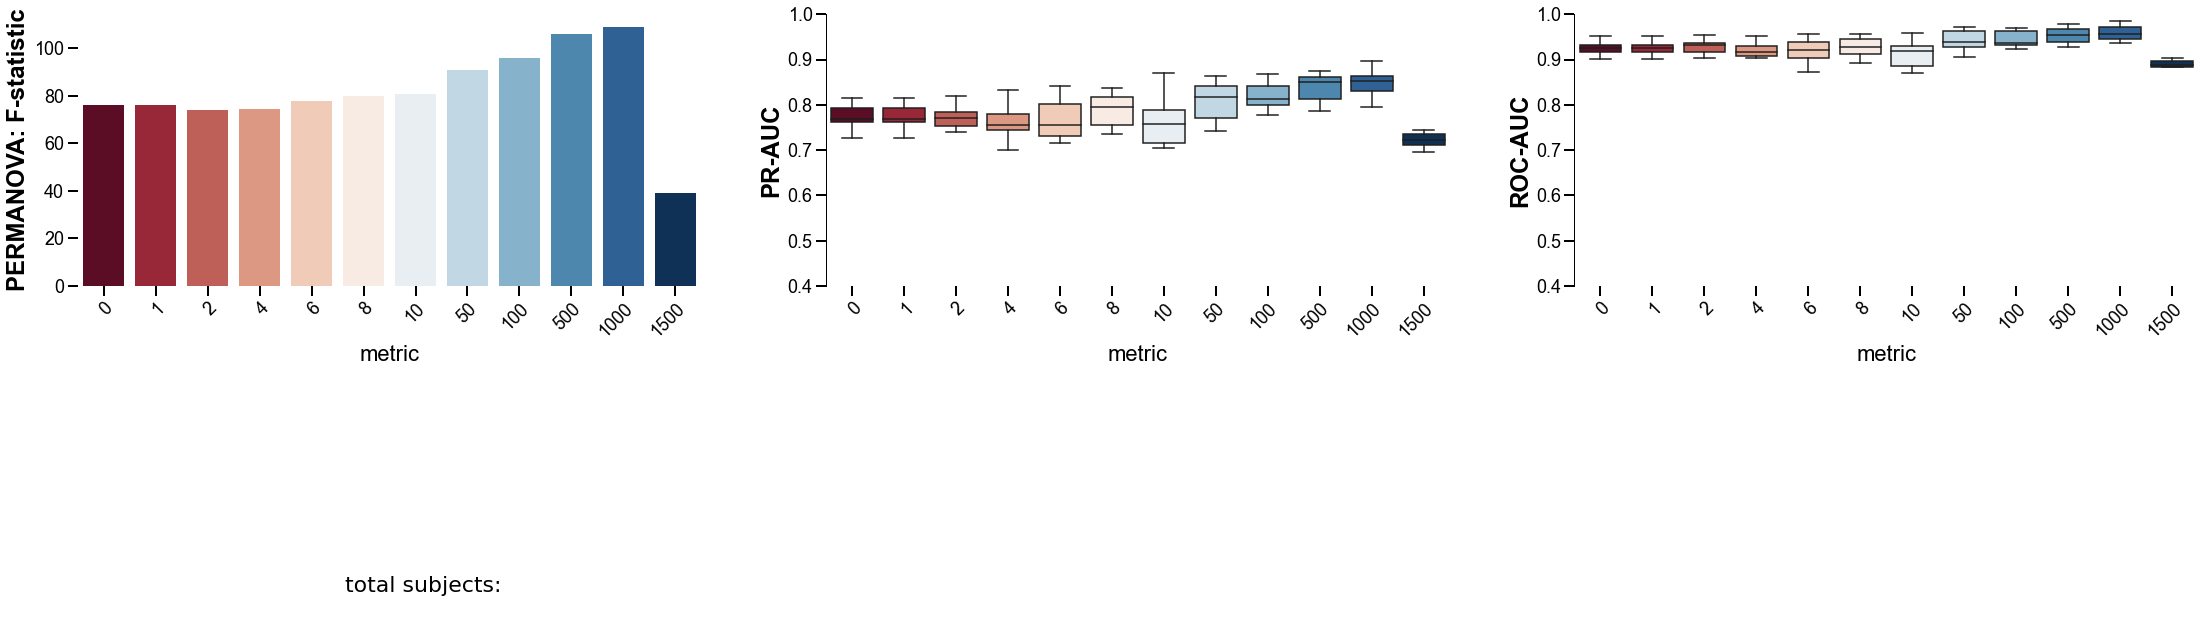

In [49]:
from matplotlib.pyplot import cm

metrics_ = sorted([m for m in list(set(ml_results_all['level_1']))])
color = cm.RdBu(np.linspace(0, 1, len(metrics_)))
pallete_metric = {i:c for i, c in zip(metrics_, color)}


fig, axn = plt.subplots(1, 3, figsize=(38, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.barplot(x='level_1', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, )
        ax.spines['left'].set_bounds(0, )        
    else:

        sns.boxplot(x='level_1', y='score', palette=pallete_metric,
                    order=pallete_metric.keys(),
                    data=pltdf, ax=ax, showfliers=False)
        #sns.swarmplot(x='method', y='score', hue='level_1', palette=pallete_depth,
        #              s=2, data=pltdf, dodge=True, ax=ax)
        ax.set_ylim(0.4, 1)
        ax.spines['left'].set_bounds(0.4, 1)

        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 1))
        
    #ax.legend_.remove()

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    ax.set_xlabel('metric',
                  fontsize=22,
                  family = 'arial',
                  weight='normal',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  family = 'arial',
                  weight='bold',
                  color='black')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels,
                   loc=2, 
                         bbox_to_anchor=(-2.0, -1.0),
                         prop={'size':20},
                         title="total subjects:",
                         fancybox=False, framealpha=.0,
                         ncol=7, markerscale=2.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
plt.show()